# Train Model and Generate Images

## Load the libraries

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import pytorch_lightning as pl
import torch.nn.functional as F

# Importing library from huggingface diffusers
from diffusers import UNet2DModel, DDPMScheduler


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.4.0+cu118 with CUDA 1108 (you have 2.4.1+cu121)
    Python  3.8.19 (you have 3.8.10)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/home/dsk2v/.local/lib/python3.8/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/dsk2v/.local/li

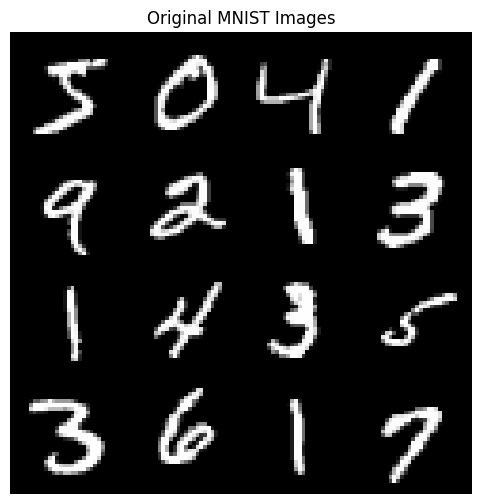

In [5]:
import torchvision
import matplotlib.pyplot as plt

# Load a few MNIST test images
mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
images = torch.stack([mnist[i][0] for i in range(16)])  # Pick 8 samples

# Display
grid = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.title("Original MNIST Images")
plt.axis("off")
plt.show()


### This class defines a PyTorch LightningModule for training a DDPM (Denoising Diffusion Probabilistic Model) on the MNIST dataset. 

### It wraps the training logic, model architecture (UNet), noise scheduling, and optimization in a modular and scalable way. 

### Train the model to learn the reverse diffusion process: starting from pure noise and progressively generating realistic MNIST digits.


In [6]:
class MNISTDDPM(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        # Define the UNet 2D model
        self.model = UNet2DModel(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128),
            down_block_types=("DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D"),
        )
        # Initialize the noise scheduler for the diffusion process with 1000 timesteps.
        self.noise_scheduler = DDPMScheduler(num_train_timesteps=1000) 
        
        # Set the actual timesteps used during inference or sampling.
        # This ensures the scheduler generates a consistent schedule for denoising steps.
        self.noise_scheduler.set_timesteps(1000)
        self.lr = lr

    # Given a noisy image `x` and a timestep `t`, predict the added noise using the UNet model.
    # sample: extracts the actual denoised output
    def forward(self, x, t):
        return self.model(x, t).sample

    def training_step(self, batch, batch_idx):
        # Get the input images from the batch
        imgs, _ = batch
        
        # Generate random Gaussian noise with the same shape as the images.
        noise = torch.randn_like(imgs)
        
        # Sample a random timestep for each image in the batch, to add to the images
        timesteps = torch.randint(0, self.noise_scheduler.num_train_timesteps, (imgs.shape[0],), device=self.device).long()

        # Add noise to the original images according to the selected timesteps.
        noisy_imgs = self.noise_scheduler.add_noise(imgs, noise, timesteps)

        # Reverse learning: Predict the noise added to the images using the model.
        noise_pred = self(noisy_imgs, timesteps)

        # Calculate the loss between the predicted noise and the actual noise.
        loss = F.mse_loss(noise_pred, noise)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

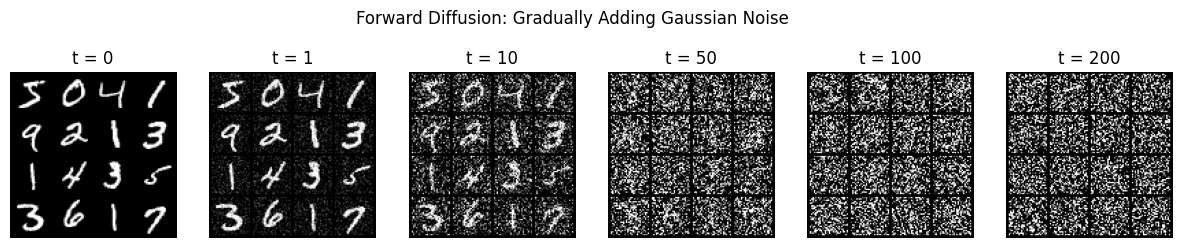

In [7]:
import torch
import numpy as np

def add_noise(images, t, beta=0.02):
    noise = torch.randn_like(images)
    alpha = 1 - beta
    alpha_bar = alpha ** t
    return (alpha_bar ** 0.5) * images + ((1 - alpha_bar) ** 0.5) * noise

# Show same image progressively noised
timesteps = [1, 10, 50, 100, 200]
noised_imgs = [add_noise(images, t).clamp(0, 1) for t in timesteps]
noised_imgs.insert(0, images)  # include original

# Display as grid
fig, axes = plt.subplots(1, len(noised_imgs), figsize=(15, 3))
for i, img_set in enumerate(noised_imgs):
    grid = torchvision.utils.make_grid(img_set, nrow=4)
    axes[i].imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
    axes[i].set_title(f"t = {0 if i==0 else timesteps[i-1]}")
    axes[i].axis("off")
plt.suptitle("Forward Diffusion: Gradually Adding Gaussian Noise")
plt.show()


In [19]:
# Define data loader
def get_dataloader(batch_size=128):
    # Preprocess the training data (resize, to tensor, normalize)
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)  # Normalize to [-1, 1]
    ])
    dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Training
if __name__ == "__main__":
    dataloader = get_dataloader()
    model = MNISTDDPM()
    trainer = pl.Trainer(
        max_epochs=25, # train for 25 epochs
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        default_root_dir="checkpoints",
        log_every_n_steps=10
    )

    # Fit the model
    trainer.fit(model, dataloader)

    # Save the trained model
    torch.save(model.state_dict(), "mnist_ddpm.pt")

    

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | UNet2DModel | 3.7 M  | train
----------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.634    Total estimated model params size (MB)
140       Modules in train mode
0         Modules in eval mod

Epoch 0:   0%|          | 2/469 [00:00<00:47,  9.80it/s, v_num=3]

/home/dsk2v/.local/lib/python3.8/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 24: 100%|██████████| 469/469 [00:37<00:00, 12.66it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 469/469 [00:37<00:00, 12.59it/s, v_num=3]


## Generate Images from random noise

In [17]:
import torch
from diffusers import UNet2DModel, DDPMScheduler

def sample_images(model, noise_scheduler, num_images=16, device="cuda"):
    model.eval()
    last_steps = []  # to store last 5 steps
    with torch.no_grad():
        # Random noise initialization
        x = torch.randn((num_images, 1, 28, 28)).to(device)
        
        # Reverse diffusion process
        for t in reversed(range(noise_scheduler.num_train_timesteps)):
            timesteps = torch.full((num_images,), t, device=device, dtype=torch.long)
            noise_pred = model(x, timesteps)
            x = noise_scheduler.step(noise_pred, t, x).prev_sample

            # Save last 5 steps for visualization
            if t in [800, 400, 200, 10]:  # assuming total steps ~50–100
                last_steps.append(x.clone().detach().cpu())

        # Post-process the images (scaling back to [0, 1])
        x = (x.clamp(-1, 1) + 1) / 2  # Scale to [0, 1]
        final_images = x
    return final_images, last_steps


# Initialize the model (same configuration as during training)
model = MNISTDDPM()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load the model weights (checkpoint) saved using model.state_dict()
checkpoint = torch.load("mnist_ddpm.pt", map_location="cuda")
model.load_state_dict(checkpoint)  # Directly load the state_dict without strict=False since the architecture should match

# Load the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler.set_timesteps(1000) 

# Generate images
generated_images, last_5steps_generated_images = sample_images(model, noise_scheduler, num_images=16)


/tmp/ipykernel_135558/1877535365.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("mnist_ddpm.pt", map_location="cuda")
/home/dsk2v/.local/lib/py

In [27]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_denoising_steps(last_steps):
    fig, axes = plt.subplots(1, len(last_steps), figsize=(15, 3))
    timesteps = [800, 400, 200, 10]
    for i, img_batch in enumerate(last_steps):
        img = (img_batch.clamp(0, 1))  # safety clamp
        grid = vutils.make_grid(img, nrow=4)
        axes[i].imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
        axes[i].set_title(f"Step {timesteps[i]}")
        axes[i].axis("off")
    plt.suptitle("Last 5 Denoising Steps During Inference")
    plt.tight_layout()
    plt.show()


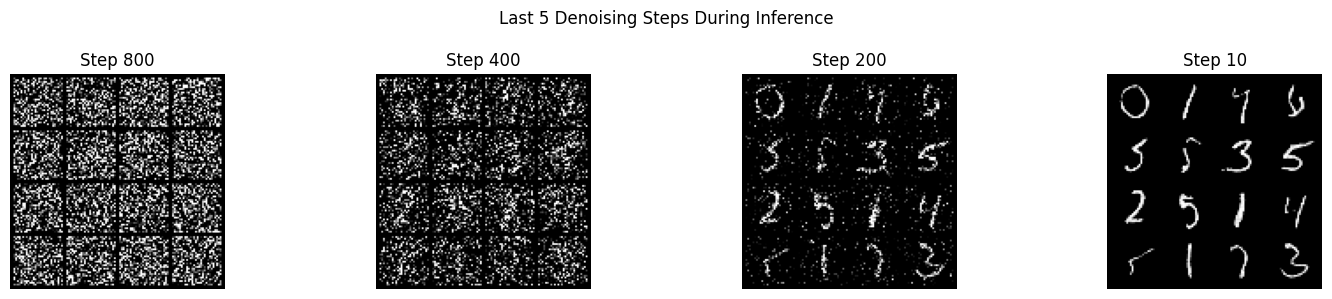

In [28]:

plot_denoising_steps(last_5steps_generated_images)


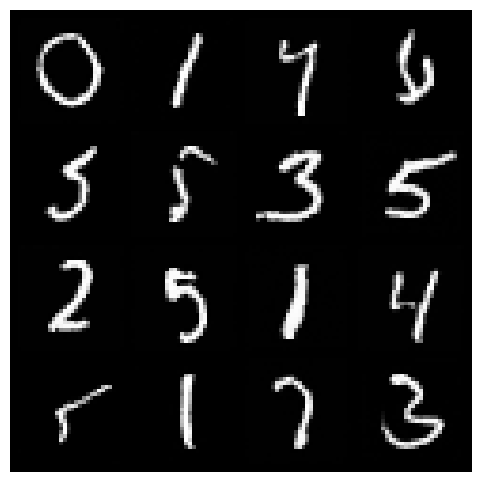

In [20]:
import matplotlib.pyplot as plt
import torchvision

# Convert tensor to grid image
grid_img = torchvision.utils.make_grid(generated_images, nrow=4)

# Convert to numpy and show
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.show()
